In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

Device set to use cuda:0


In [ ]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

In [ ]:
class PerformanceBenchmark:
  def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
    self.pipeline = pipeline
    self.dataset = dataset
    self.optim_type = optim_type

  def compute_accuracy(self):
  # We'll define this later
    pass

  def compute_size(self):
  # We'll define this later
    pass

  def time_pipeline(self):
  # We'll define this later
    pass

  def run_benchmark(self):
    metrics = {}
    metrics[self.optim_type] = self.compute_size()
    metrics[self.optim_type].update(self.time_pipeline())
    metrics[self.optim_type].update(self.compute_accuracy())
    return metrics

In [ ]:
!pip install datasets
import datasets

In [ ]:
from datasets import load_dataset

clinc = load_dataset('clinc_oos', "plus")

In [ ]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [ ]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [ ]:
!pip install evaluate

from evaluate import load

In [ ]:
accuracy_score = load("accuracy")

In [ ]:
def compute_accuracy(self):
  """This overrides the PerformanceBenchmark.compute_accuracy() method"""
  preds, labels = [], []
  for example in self.dataset:
    pred = self.pipeline(example["text"])[0]["label"]
    label = example["intent"]
    preds.append(intents.str2int(pred))
    labels.append(label)
  accuracy = accuracy_score.compute(predictions=preds, references=labels)
  print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
  return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [ ]:
import torch

torch.save(pipe.model.state_dict(), "model.pt")

In [ ]:
from pathlib import Path

def compute_size(self):
  """This overrides the PerformanceBenchmark.compute_size() method"""
  state_dict = self.pipeline.model.state_dict()
  tmp_path = Path("model.pt")
  torch.save(state_dict, tmp_path)
  # Calculate size in megabytes
  size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
  # Delete temporary file
  tmp_path.unlink()
  print(f"Model size (MB) - {size_mb:.2f}")
  return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [ ]:
from time import perf_counter

for _ in range(3):
 start_time = perf_counter()
 _ = pipe(query)
 latency = perf_counter() - start_time
 print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 9.426
Latency (ms) - 9.342
Latency (ms) - 8.967


In [ ]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
  """This overrides the PerformanceBenchmark.time_pipeline() method"""
  latencies = []
  # Warmup
  for _ in range(10):
    _ = self.pipeline(query)
  # Timed run
  for _ in range(100):
    start_time = perf_counter()
    _ = self.pipeline(query)
    latency = perf_counter() - start_time
    latencies.append(latency)
  # Compute run statistics
  time_avg_ms = 1000 * np.mean(latencies)
  time_std_ms = 1000 * np.std(latencies)
  print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
  return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [ ]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15
Average latency (ms) - 8.50 +\- 1.60
Accuracy on test set - 0.867


In [ ]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
  def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
    super().__init__(*args, **kwargs)
    self.alpha = alpha
    self.temperature = temperature

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
  def __init__(self, *args, teacher_model=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.teacher_model = teacher_model

  def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None): # Add num_items_in_batch argument
    outputs_stu = model(**inputs)
    # Extract cross-entropy loss and logits from student
    loss_ce = outputs_stu.loss
    logits_stu = outputs_stu.logits
    # Extract logits from teacher
    with torch.no_grad():
      outputs_tea = self.teacher_model(**inputs)
      logits_tea = outputs_tea.logits

    # Soften probabilities and compute distillation loss
    loss_fct = nn.KLDivLoss(reduction="batchmean")
    loss_kd = self.args.temperature ** 2 * loss_fct(
    F.log_softmax(logits_stu / self.args.temperature, dim=-1),
    F.softmax(logits_tea / self.args.temperature, dim=-1))
    # Return weighted student loss
    loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
    return (loss, outputs_stu) if return_outputs else loss

In [ ]:
from transformers import AutoTokenizer
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)
def tokenize_text(batch):
 return student_tokenizer(batch["text"], truncation=True)
clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
def compute_metrics(pred):
 predictions, labels = pred
 predictions = np.argmax(predictions, axis=1)
 return accuracy_score.compute(predictions=predictions, references=labels)

In [ ]:
batch_size = 48
finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
 output_dir=finetuned_ckpt, evaluation_strategy = "epoch",
 num_train_epochs=5, learning_rate=2e-5,
 per_device_train_batch_size=batch_size,
 per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
 push_to_hub=False, report_to='none')

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [ ]:
from transformers import AutoConfig
num_labels = intents.num_classes
student_config = (AutoConfig
 .from_pretrained(student_ckpt, num_labels=num_labels,
 id2label=id2label, label2id=label2id))

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
  return (AutoModelForSequenceClassification
  .from_pretrained(student_ckpt, config=student_config).to(device))

In [ ]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
 .from_pretrained(teacher_ckpt, num_labels=num_labels)
 .to(device))
distilbert_trainer = DistillationTrainer(model_init=student_init,
 teacher_model=teacher_model, args=student_training_args,
 train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
 compute_metrics=compute_metrics, tokenizer=student_tokenizer)
distilbert_trainer.train()

<ipython-input-65-344a0738defb>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.339162,0.731290
2,3.833100,1.929527,0.846452
3,3.833100,1.202584,0.896452
4,1.751800,0.895584,0.911290
5,0.944000,0.806329,0.916129


TrainOutput(global_step=1590, training_loss=2.0981299346348026, metrics={'train_runtime': 332.3361, 'train_samples_per_second': 229.436, 'train_steps_per_second': 4.784, 'total_flos': 414689637990180.0, 'train_loss': 2.0981299346348026, 'epoch': 5.0})

In [ ]:
distilbert_trainer.push_to_hub("Training completed!")

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/navidfalah/distilbert-base-uncased-finetuned-clinc/commit/5e7eb9fb9d48de276a8dae88d9d826ff856c94cc', commit_message='Training completed!', commit_description='', oid='5e7eb9fb9d48de276a8dae88d9d826ff856c94cc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/navidfalah/distilbert-base-uncased-finetuned-clinc', endpoint='https://huggingface.co', repo_type='model', repo_id='navidfalah/distilbert-base-uncased-finetuned-clinc'), pr_revision=None, pr_num=None)

In [ ]:
finetuned_ckpt = "navidfalah/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 6.63 +\- 1.43
Accuracy on test set - 0.855


In [ ]:
perf_metrics

{'BERT baseline': {'size_mb': 418.1497859954834,
  'time_avg_ms': 8.502116489996752,
  'time_std_ms': 1.6038809880811415,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.8832492828369,
  'time_avg_ms': 6.632770269998218,
  'time_std_ms': 1.4295921236050422,
  'accuracy': 0.854909090909091}}

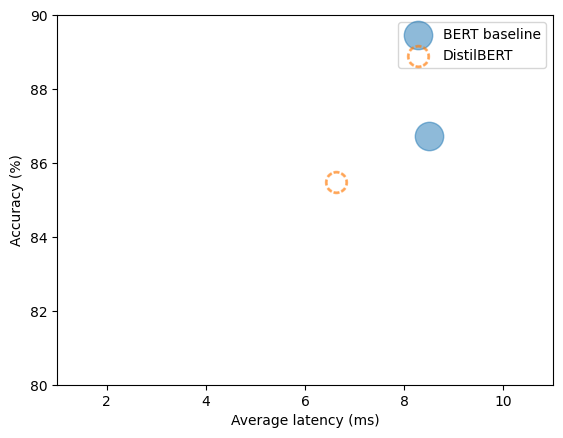

In [ ]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
  df = pd.DataFrame.from_dict(perf_metrics, orient='index')

  for idx in df.index:
    df_opt = df.loc[idx]
    # Add a dashed circle around the current optimization type
    if idx == current_optim_type:
      plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
      alpha=0.5, s=df_opt["size_mb"], label=idx,
      marker='$\u25CC$')
    else:
      plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
      s=df_opt["size_mb"], label=idx, alpha=0.5)

  legend = plt.legend(bbox_to_anchor=(1,1))

  plt.ylim(80,90)
  # Use the slowest model to define the x-axis range
  xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
  plt.xlim(1, xlim)
  plt.ylabel("Accuracy (%)")
  plt.xlabel("Average latency (ms)")
  plt.show()

plot_metrics(perf_metrics, optim_type)

In [ ]:
def objective(trial):
 x = trial.suggest_float("x", -2, 2)
 y = trial.suggest_float("y", -2, 2)
 return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [ ]:
!pip install optuna

In [ ]:
import optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-01-21 16:40:48,462] A new study created in memory with name: no-name-856c019f-ae00-4ef7-bb4b-392e5a219a6f
[I 2025-01-21 16:40:48,466] Trial 0 finished with value: 16.185771768410277 and parameters: {'x': 0.4050008682889228, 'y': -0.23386558587955797}. Best is trial 0 with value: 16.185771768410277.
[I 2025-01-21 16:40:48,468] Trial 1 finished with value: 74.32963693147393 and parameters: {'x': -0.4683046797937247, 'y': -0.6302418924923483}. Best is trial 0 with value: 16.185771768410277.
[I 2025-01-21 16:40:48,470] Trial 2 finished with value: 819.4495215084457 and parameters: {'x': 1.8793685083866158, 'y': 0.6707741095210129}. Best is trial 0 with value: 16.185771768410277.
[I 2025-01-21 16:40:48,473] Trial 3 finished with value: 128.17971828141617 and parameters: {'x': 1.6344899953095493, 'y': 1.5411720320888436}. Best is trial 0 with value: 16.185771768410277.
[I 2025-01-21 16:40:48,475] Trial 4 finished with value: 1341.842043541814 and parameters: {'x': 1.7251385382369575,

In [ ]:
study.best_params

{'x': 0.6386182860102527, 'y': 0.4198685705389035}

In [ ]:
def hp_space(trial):
 return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
 "alpha": trial.suggest_float("alpha", 0, 1),
 "temperature": trial.suggest_int("temperature", 2, 20)}

In [ ]:
best_run = distilbert_trainer.hyperparameter_search(n_trials=20, direction="maximize", hp_space=hp_space)

[I 2025-01-21 16:40:49,487] A new study created in memory with name: no-name-4d24858d-b5c7-41bb-b30e-3ced3c4927d8
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.193581,0.580968
2,0.310500,0.095194,0.820323
3,0.310500,0.064740,0.880968
4,0.110500,0.050569,0.893871
5,0.072000,0.042379,0.905806
6,0.072000,0.037695,0.910645
7,0.058000,0.035507,0.912903
8,0.052200,0.034571,0.915484


[I 2025-01-21 16:49:45,592] Trial 0 finished with value: 0.915483870967742 and parameters: {'num_train_epochs': 8, 'alpha': 0.3349336966613464, 'temperature': 16}. Best is trial 0 with value: 0.915483870967742.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.231790,0.611613
2,0.369800,0.106352,0.835161
3,0.369800,0.068163,0.883871
4,0.124200,0.051430,0.897097
5,0.076700,0.042067,0.913871
6,0.076700,0.037168,0.914839
7,0.060500,0.034859,0.919355
8,0.054100,0.033873,0.920323


[I 2025-01-21 16:58:19,769] Trial 1 finished with value: 0.9203225806451613 and parameters: {'num_train_epochs': 8, 'alpha': 0.6759584819846081, 'temperature': 5}. Best is trial 1 with value: 0.9203225806451613.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.191210,0.584194
2,0.308200,0.093294,0.823871
3,0.308200,0.062874,0.883871
4,0.108400,0.048641,0.895161
5,0.069600,0.040289,0.906774
6,0.069600,0.035369,0.914516
7,0.055100,0.032794,0.918387
8,0.048500,0.030916,0.919032
9,0.048500,0.030429,0.919677


[I 2025-01-21 17:08:01,271] Trial 2 finished with value: 0.9196774193548387 and parameters: {'num_train_epochs': 9, 'alpha': 0.9956752812549228, 'temperature': 17}. Best is trial 1 with value: 0.9203225806451613.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.298120,0.633548
2,0.465700,0.128259,0.836129
3,0.465700,0.078851,0.882258
4,0.149600,0.059810,0.897419
5,0.090900,0.050690,0.908387
6,0.090900,0.048245,0.908710


[I 2025-01-21 17:14:19,356] Trial 3 finished with value: 0.9087096774193548 and parameters: {'num_train_epochs': 6, 'alpha': 0.18594280657501228, 'temperature': 3}. Best is trial 1 with value: 0.9203225806451613.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.196517,0.569355
2,0.312000,0.099980,0.810645
3,0.312000,0.070411,0.870000
4,0.115700,0.057336,0.886129
5,0.079500,0.050380,0.890968
6,0.079500,0.048274,0.892258


[I 2025-01-21 17:20:42,276] Trial 4 finished with value: 0.892258064516129 and parameters: {'num_train_epochs': 6, 'alpha': 0.6148483883594259, 'temperature': 17}. Best is trial 1 with value: 0.9203225806451613.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.253421,0.621290
2,0.401100,0.113980,0.837742
3,0.401100,0.072225,0.881935


[I 2025-01-21 17:23:47,229] Trial 5 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.409340,0.667097
2,0.643400,0.139469,0.842258
3,0.643400,0.072721,0.900000
4,0.163500,0.052254,0.914516
5,0.081700,0.042965,0.927097
6,0.081700,0.038295,0.929355
7,0.061700,0.036040,0.930645
8,0.054000,0.034179,0.931290
9,0.054000,0.033684,0.932581


[I 2025-01-21 17:33:46,225] Trial 6 finished with value: 0.9325806451612904 and parameters: {'num_train_epochs': 9, 'alpha': 0.40208043417329586, 'temperature': 2}. Best is trial 6 with value: 0.9325806451612904.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.222836,0.602258
2,0.354100,0.105932,0.830645
3,0.354100,0.070181,0.879677


[I 2025-01-21 17:36:54,260] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.194133,0.587097


[I 2025-01-21 17:37:55,199] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.193637,0.572258


[I 2025-01-21 17:38:56,080] Trial 9 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.202673,0.600000
2,0.326600,0.095834,0.834194
3,0.326600,0.062788,0.885806


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.202673,0.600000
2,0.326600,0.095834,0.834194
3,0.326600,0.062788,0.885806
4,0.111700,0.047596,0.897097
5,0.069700,0.038749,0.914194
6,0.069700,0.033616,0.917742
7,0.054100,0.030837,0.920968
8,0.046800,0.028553,0.923871
9,0.046800,0.027652,0.926774
10,0.043300,0.027231,0.927097


[I 2025-01-21 17:50:47,457] Trial 10 finished with value: 0.9270967741935484 and parameters: {'num_train_epochs': 10, 'alpha': 0.002619766329932549, 'temperature': 9}. Best is trial 6 with value: 0.9325806451612904.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.199947,0.597742


[I 2025-01-21 17:51:48,793] Trial 11 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.206153,0.604516
2,0.332200,0.096866,0.832903


[I 2025-01-21 17:54:32,658] Trial 12 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.197033,0.589677


[I 2025-01-21 17:55:33,766] Trial 13 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.406152,0.668710
2,0.641200,0.136141,0.843226
3,0.641200,0.070551,0.901935
4,0.160100,0.050601,0.916452
5,0.079200,0.041647,0.927097
6,0.079200,0.036911,0.929032
7,0.059500,0.034658,0.932258
8,0.051500,0.032448,0.932258
9,0.051500,0.031673,0.934194
10,0.047800,0.031169,0.936129


[I 2025-01-21 18:06:43,605] Trial 14 finished with value: 0.9361290322580645 and parameters: {'num_train_epochs': 10, 'alpha': 0.43572172878680876, 'temperature': 2}. Best is trial 14 with value: 0.9361290322580645.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.432475,0.658387
2,0.659800,0.170884,0.823548


[I 2025-01-21 18:08:48,617] Trial 15 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.212189,0.604194


[I 2025-01-21 18:09:49,436] Trial 16 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.188628,0.581613


[I 2025-01-21 18:10:50,345] Trial 17 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.291249,0.640323
2,0.461000,0.119191,0.840323
3,0.461000,0.070140,0.891290
4,0.139900,0.051240,0.903548
5,0.079900,0.041528,0.920000
6,0.079900,0.036894,0.921290
7,0.061900,0.034704,0.925484
8,0.055200,0.033727,0.924516


[I 2025-01-21 18:19:26,604] Trial 18 finished with value: 0.9245161290322581 and parameters: {'num_train_epochs': 8, 'alpha': 0.3412585917680254, 'temperature': 3}. Best is trial 14 with value: 0.9361290322580645.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.409340,0.667097
2,0.643400,0.139469,0.842258
3,0.643400,0.072721,0.900000
4,0.163500,0.052254,0.914516
5,0.081700,0.042965,0.927097
6,0.081700,0.038295,0.929355
7,0.061700,0.036040,0.930645
8,0.054000,0.034179,0.931290
9,0.054000,0.033684,0.932581


[I 2025-01-21 18:29:10,070] Trial 19 finished with value: 0.9325806451612904 and parameters: {'num_train_epochs': 9, 'alpha': 0.1660039968053496, 'temperature': 2}. Best is trial 14 with value: 0.9361290322580645.


In [ ]:
print(best_run)

BestRun(run_id='14', objective=0.9361290322580645, hyperparameters={'num_train_epochs': 10, 'alpha': 0.43572172878680876, 'temperature': 2}, run_summary=None)


In [ ]:
for k,v in best_run.hyperparameters.items():
 setattr(student_training_args, k, v)
# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt
# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
 teacher_model=teacher_model, args=student_training_args,
 train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
 compute_metrics=compute_metrics, tokenizer=student_tokenizer)
distil_trainer.train();

<ipython-input-65-344a0738defb>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.678825,0.720000
2,2.025200,0.854775,0.866452
3,2.025200,0.497277,0.915484
4,0.774300,0.365837,0.932258
5,0.364500,0.315468,0.939677
6,0.364500,0.297976,0.941613
7,0.260300,0.287528,0.943226
8,0.228200,0.280832,0.943548
9,0.228200,0.277947,0.945161
10,0.216600,0.276304,0.945161


In [ ]:
distil_trainer.push_to_hub("Training complete")

In [ ]:
distilled_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

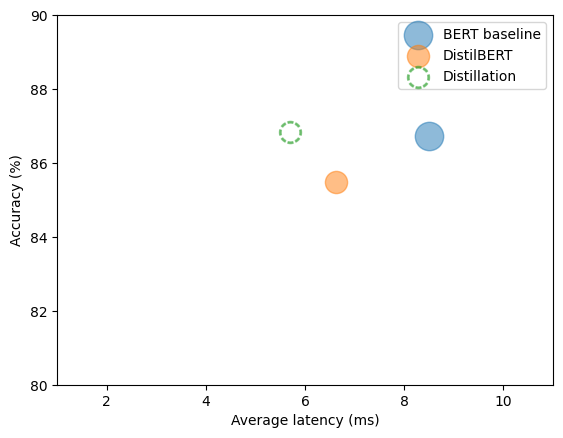

In [ ]:
plot_metrics(perf_metrics, optim_type)

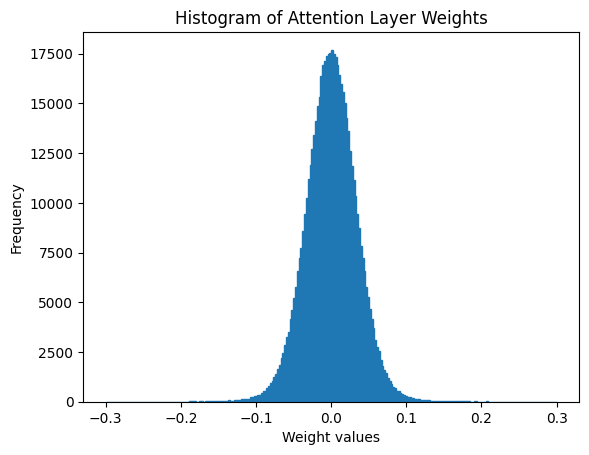

In [ ]:
import matplotlib.pyplot as plt
import torch  # Ensure PyTorch is imported

# Assuming 'pipe.model.state_dict()' is a valid way to access the model state dictionary
state_dict = pipe.model.state_dict()

# Extract the weights of a specific layer
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]

# Plot the histogram of the flattened weights
plt.hist(weights.cpu().numpy().flatten(), bins=250, range=(-0.3, 0.3), edgecolor="C0")
plt.xlabel("Weight values")
plt.ylabel("Frequency")
plt.title("Histogram of Attention Layer Weights")
plt.show()

In [ ]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [ ]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], device='cuda:0',
       dtype=torch.int8)

In [ ]:
from torch import quantize_per_tensor
dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], device='cuda:0',
       dtype=torch.int8)

In [ ]:
%%timeit
weights @ weights

225 µs ± 2.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
from torch.nn.quantized import QFunctional
q_fn = QFunctional()

In [ ]:
from torch.quantization import quantize_dynamic
model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
 .from_pretrained(model_ckpt).to("cpu"))
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

In [ ]:
pipe = pipeline("text-classification", model=model_quantized,
 tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Device set to use cuda:0


Model size (MB) - 132.39


NotImplementedError: Could not run 'quantized::linear_dynamic' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear_dynamic' is only available for these backends: [CPU, Meta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at ../aten/src/ATen/native/quantized/cpu/qlinear_dynamic.cpp:791 [kernel]
Meta: registered at ../aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:96 [backend fallback]
AutogradOther: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMPS: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:87 [backend fallback]
AutogradXPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:100 [backend fallback]
AutogradLazy: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMeta: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:91 [backend fallback]
Tracer: registered at ../torch/csrc/autograd/TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:321 [backend fallback]
AutocastXPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:463 [backend fallback]
AutocastMPS: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:157 [backend fallback]


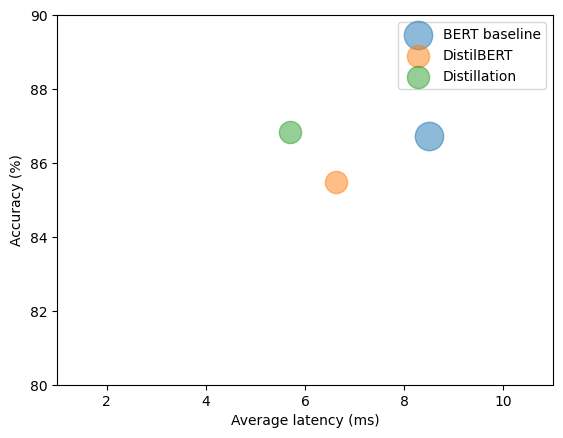

In [ ]:
plot_metrics(perf_metrics, optim_type)

In [ ]:
from torch.quantization import quantize_dynamic

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
 .from_pretrained(model_ckpt).to("cpu"))
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

NameError: name 'AutoTokenizer' is not defined

In [ ]:
pipe = pipeline("text-classification", model=model_quantized,
 tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

NameError: name 'pipeline' is not defined

In [ ]:
plot_metrics(perf_metrics, optim_type)

NameError: name 'plot_metrics' is not defined

In [ ]:
import os
from psutil import cpu_count
os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [ ]:
from transformers.convert_graph_to_onnx import convert
model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
 output=onnx_model_path, opset=12, pipeline_name="text-classification")

NameError: name 'Path' is not defined